## Regression Project

Build a linear regression model that predicts the `price` column in the dataset on San Francisco Apartment rentals. Make sure to go through all the the relevant steps of the modelling workflow.

1. Data Cleaning has already been performed on this data
2. Explore the data, keeping an eye on useful features and potential issues 
3. Choose a model validation scheme (simple or cross validation)
4. Fit a Linear Regression Model
5. Evaluate your model - check assumptions, metrics, and coefficient estimates
6. Engineer Features as needed
7. Repeat Steps 2, 4, 5, 6 as needed
8. Once you are ready, fit your final model and report final model performance estimate by scoring on the test data. Report both test R-squared and MAE.

A reasonable goal is to get a validation MAE of <= 500 dollars.

Advice:

1. "Perfect" is the enemy of "Good".
2. You will not get to an MAE of 0, we don't have perfect data, and there is some randomness and emotion in how things like apartment prices are set. 
3. Modelling is challenging, especially if you're new. There isn't a "right" answer, but some models are better than others. Remember - "All Models are wrong, but some are useful" 
4. We will likely end up with different models and performance metrics, and that's ok. You can always implement new ideas after watching the solution video. I didn't do anything too fancy, so you might think of some great ideas I didn't!
5. Enjoy the process, and remember that at some point it's time to let the model go. No amount of feature engineering will achieve a perfect model.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse

rentals_df = pd.read_csv("../Data/sf_clean.csv") 
rentals_df.head()

,price,sqft,beds,bath,laundry,pets,housing_type,parking,hood_district
0,6800,1600.0,2.0,2.0,(a) in-unit,(d) no pets,(c) multi,(b) protected,7.0
1,3500,550.0,1.0,1.0,(a) in-unit,(a) both,(c) multi,(b) protected,7.0
2,5100,1300.0,2.0,1.0,(a) in-unit,(a) both,(c) multi,(d) no parking,7.0
3,9000,3500.0,3.0,2.5,(a) in-unit,(d) no pets,(c) multi,(b) protected,7.0
4,3100,561.0,1.0,1.0,(c) no laundry,(a) both,(c) multi,(d) no parking,7.0


### Data Dictionary

1. Price: The price of the rental and our target variable
2. sqft: The area in square feet of the rental
3. beds: The number of bedrooms in the rental
4. bath: The number of bathrooms in the rental
5. laundry: Does the rental have a laundry machine inside the house, a shared laundry machine, or no laundry on site?
6. pets: Does the rental allow pets? Cats only, dogs only or both cats and dogs?
7. Housing type: Is the rental in a multi-unit building, a building with two units, or a stand alone house? 
8. Parking: Does the apartment off a parking space? No, protected in a garage, off-street in a parking lot, or valet service?
9. Hood district: Which part of San Francisco is the apartment located?

![image info](SFAR_map.png)

In [2]:
rentals_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 989 entries, 0 to 988
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          989 non-null    int64  
 1   sqft           989 non-null    float64
 2   beds           989 non-null    float64
 3   bath           989 non-null    float64
 4   laundry        989 non-null    object 
 5   pets           989 non-null    object 
 6   housing_type   989 non-null    object 
 7   parking        989 non-null    object 
 8   hood_district  989 non-null    float64
dtypes: float64(4), int64(1), object(4)
memory usage: 69.7+ KB


In [33]:
rentals_df['hood_district'] = rentals_df['hood_district'].astype('object')

In [3]:
rentals_df.laundry.value_counts()

(a) in-unit       488
(b) on-site       370
(c) no laundry    131
Name: laundry, dtype: int64

In [4]:
rentals_df.pets.value_counts()

(d) no pets    510
(a) both       367
(c) cats        91
(b) dogs        21
Name: pets, dtype: int64

In [5]:
rentals_df.housing_type.value_counts()

(c) multi     937
(a) single     40
(b) double     12
Name: housing_type, dtype: int64

In [6]:
rentals_df.parking.value_counts()

(d) no parking    478
(b) protected     439
(c) off-street     38
(a) valet          34
Name: parking, dtype: int64

## EDA


In [34]:
rentals_df.describe()

,price,sqft,beds,bath
count,989.000000,989.000000,989.000000,989.000000
mean,3595.035389,976.765420,1.679474,1.390293
std,1546.222670,474.629798,1.076710,0.562714
min,750.000000,150.000000,0.000000,1.000000
25%,2650.000000,650.000000,1.000000,1.000000
50%,3300.000000,900.000000,2.000000,1.000000
75%,4242.000000,1200.000000,2.000000,2.000000
max,19000.000000,3500.000000,6.000000,4.000000


<Axes: xlabel='price', ylabel='Count'>

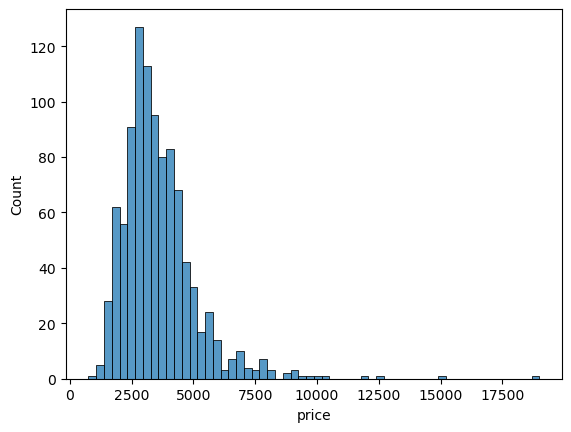

In [35]:
sns.histplot(rentals_df, x='price')

In [36]:
rentals_df.corr(numeric_only=True)

,price,sqft,beds,bath
price,1.000000,0.835834,0.673328,0.691190
sqft,0.835834,1.000000,0.765070,0.720929
beds,0.673328,0.765070,1.000000,0.629331
bath,0.691190,0.720929,0.629331,1.000000


<Axes: xlabel='sqft', ylabel='beds'>

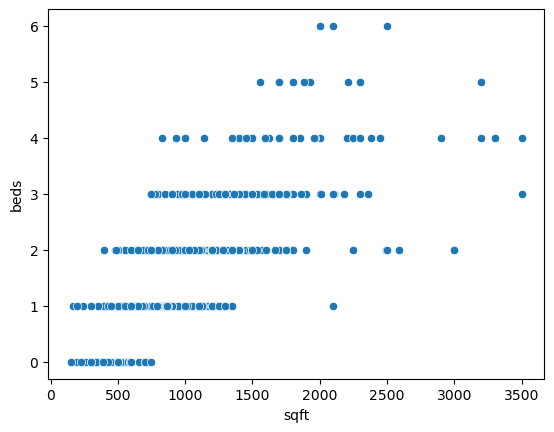

In [8]:
sns.scatterplot(data=rentals_df, x='sqft', y='beds')

<Axes: xlabel='beds', ylabel='sqft'>

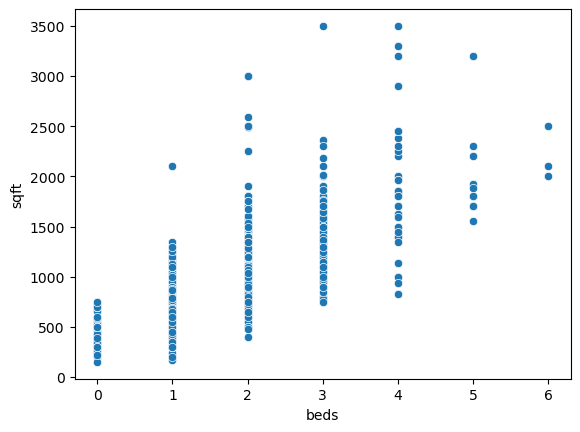

In [9]:
sns.scatterplot(data=rentals_df, x='beds', y='sqft')

<Axes: xlabel='sqft', ylabel='price'>

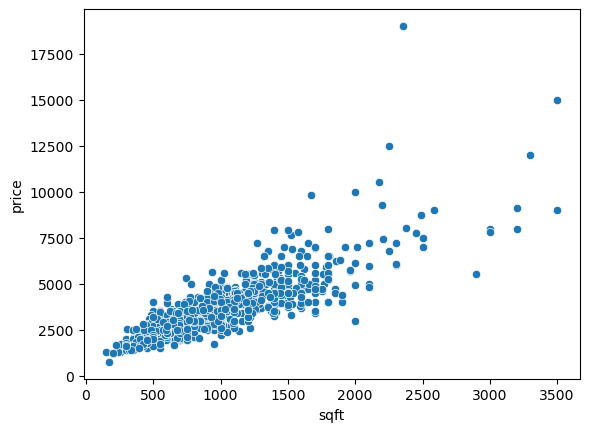

In [11]:
sns.scatterplot(data=rentals_df, x='sqft', y='price')

In [14]:
rentals_df[rentals_df['price'] > 17500]

,price,sqft,beds,bath,laundry,pets,housing_type,parking,hood_district
253,19000,2358.0,3.0,3.5,(a) in-unit,(d) no pets,(c) multi,(a) valet,9.0


In [20]:
rentals_df[(rentals_df['price'] >= 12500)]

,price,sqft,beds,bath,laundry,pets,housing_type,parking,hood_district
11,15000,3500.0,4.0,3.5,(a) in-unit,(d) no pets,(a) single,(b) protected,1.0
253,19000,2358.0,3.0,3.5,(a) in-unit,(d) no pets,(c) multi,(a) valet,9.0
602,12500,2250.0,2.0,2.5,(a) in-unit,(a) both,(c) multi,(a) valet,9.0


In [21]:
rentals_df[(rentals_df['price'] >= 10000)]

,price,sqft,beds,bath,laundry,pets,housing_type,parking,hood_district
11,15000,3500.0,4.0,3.5,(a) in-unit,(d) no pets,(a) single,(b) protected,1.0
206,10000,2000.0,6.0,2.0,(a) in-unit,(d) no pets,(a) single,(c) off-street,7.0
253,19000,2358.0,3.0,3.5,(a) in-unit,(d) no pets,(c) multi,(a) valet,9.0
602,12500,2250.0,2.0,2.5,(a) in-unit,(a) both,(c) multi,(a) valet,9.0
766,10500,2179.0,3.0,3.0,(a) in-unit,(d) no pets,(c) multi,(b) protected,8.0
927,12000,3300.0,4.0,4.0,(a) in-unit,(a) both,(c) multi,(b) protected,9.0


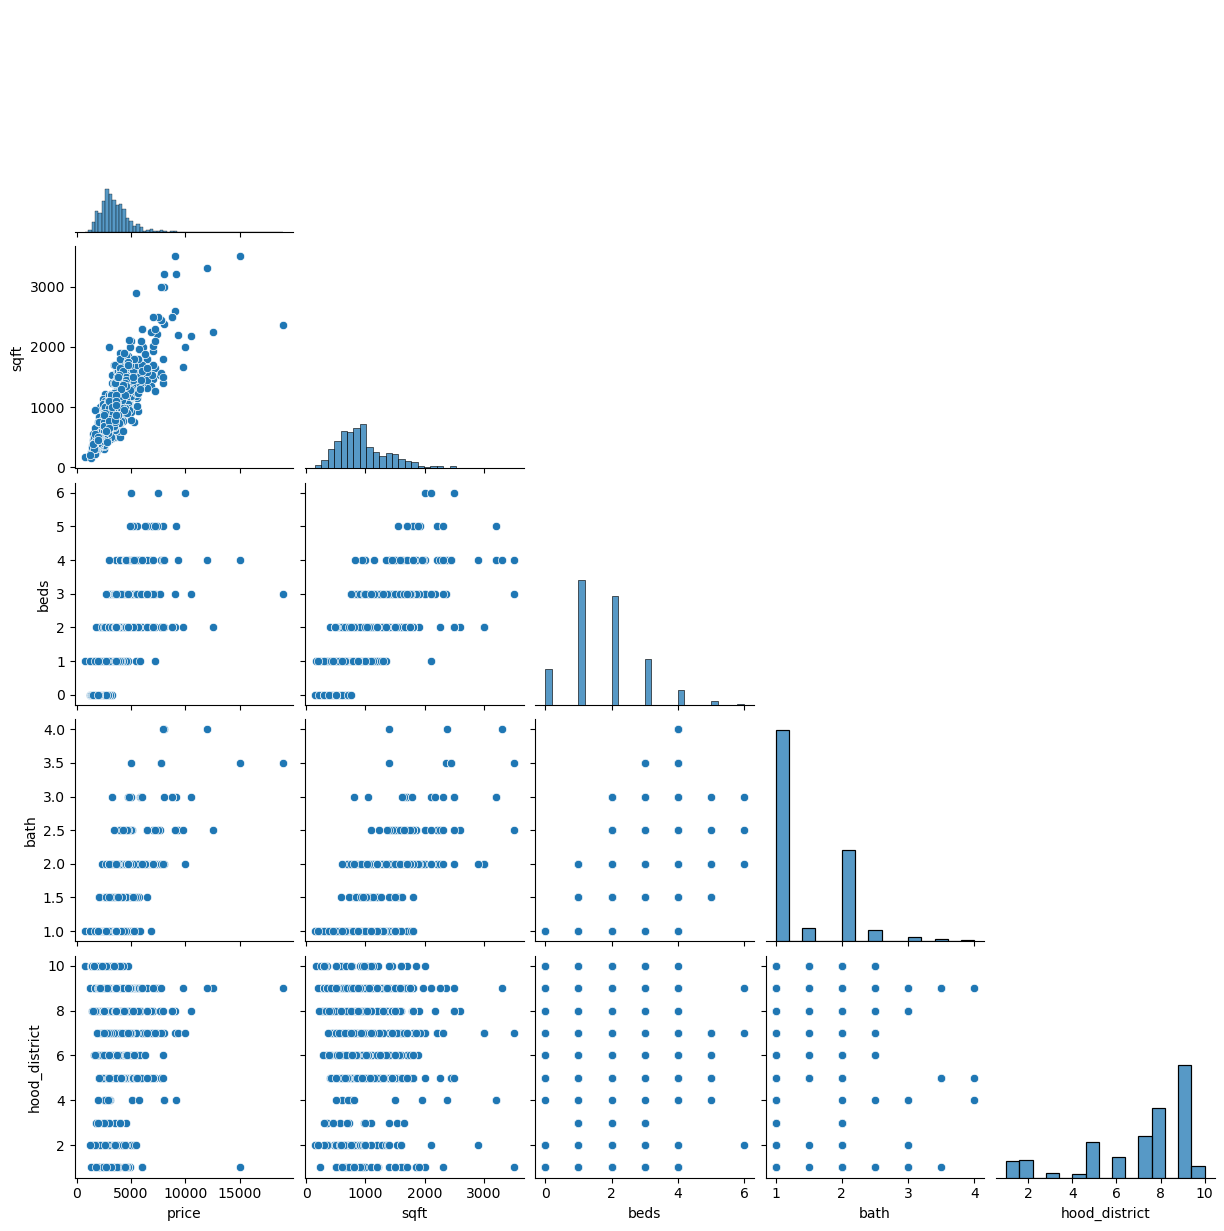

In [13]:
sns.pairplot(data=rentals_df, corner=True)

### Conclusion 

1. The most strongest correlation in our `rentals_df` is `price` and `sqft` with number of corr: `0.835834`
2. There is some extreme outlier in terms of price and sqft which fall in price of `19.000`

## Feature Engineering


In [27]:
rentals_df.head()

,price,sqft,beds,bath,laundry,pets,housing_type,parking,hood_district
0,6800,1600.0,2.0,2.0,(a) in-unit,(d) no pets,(c) multi,(b) protected,7.0
1,3500,550.0,1.0,1.0,(a) in-unit,(a) both,(c) multi,(b) protected,7.0
2,5100,1300.0,2.0,1.0,(a) in-unit,(a) both,(c) multi,(d) no parking,7.0
3,9000,3500.0,3.0,2.5,(a) in-unit,(d) no pets,(c) multi,(b) protected,7.0
4,3100,561.0,1.0,1.0,(c) no laundry,(a) both,(c) multi,(d) no parking,7.0


In [37]:
laundry_map = {
    "(a) in-unit": 'in_unit',
    '(b) on-site': 'not_in_unit',
    '(c) no laundry': 'not_in_unit'
}

pet_map = {
    '(a) both': 'allow_dogs',
    '(b) dogs': 'allow_dogs',
    '(c) cats': 'no_dogs',
    '(d) no pets': 'no_dogs'
}

housing_type_map = {
    '(a) single': 'single',
    '(b) double': 'multi',
    '(c) multi': 'multi'
}

district_map = {
    1.0: 'west',
    2.0: 'southwest',
    3.0: 'southwest',
    4.0: 'central',
    5.0: 'central',
    6.0: 'central',
    7.0: 'marina',
    8.0: 'north_beach',
    9.0: 'FiDi/SOMA',
    10.0: 'southwest'
}

In [73]:
eng_df = rentals_df.assign(
    hood_district = rentals_df['hood_district'].map(district_map),
    housing_type = rentals_df['housing_type'].map(housing_type_map),
    pets = rentals_df['pets'].map(pet_map),
    laundry = rentals_df['laundry'].map(laundry_map),
#     sqft2 = rentals_df['sqft'] ** 2,
#     sqft3 = rentals_df['sqft'] ** 3,
#     beds2 = rentals_df['beds'] ** 2,
#     beds3 = rentals_df['beds'] ** 3,
#     bath2 = rentals_df['bath'] ** 2,
#     bath3 = rentals_df['bath'] ** 3
    beds_bath_ratio = rentals_df['beds'] / rentals_df['bath']
)

eng_df = pd.get_dummies(eng_df, drop_first=True)

## Data Splitting

In [74]:
eng_df.head()

,price,sqft,beds,bath,beds_bath_ratio,laundry_not_in_unit,pets_no_dogs,housing_type_single,parking_(b) protected,parking_(c) off-street,parking_(d) no parking,hood_district_central,hood_district_marina,hood_district_north_beach,hood_district_southwest,hood_district_west
0,6800,1600.0,2.0,2.0,1.0,0,1,0,1,0,0,0,1,0,0,0
1,3500,550.0,1.0,1.0,1.0,0,0,0,1,0,0,0,1,0,0,0
2,5100,1300.0,2.0,1.0,2.0,0,0,0,0,0,1,0,1,0,0,0
3,9000,3500.0,3.0,2.5,1.2,0,1,0,1,0,0,0,1,0,0,0
4,3100,561.0,1.0,1.0,1.0,1,0,0,0,0,1,0,1,0,0,0


In [75]:
from sklearn.model_selection import train_test_split 

target = 'price'
drop_cols = [
    'pets_no_dogs',
    'housing_type_single',
    'beds_bath_ratio'
]

X = sm.add_constant(eng_df.drop([target] + drop_cols, axis=1))

# Log transform sligtly improves normality 
y = np.log(eng_df[target])
# y = eng_df[target]

X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=2023)

In [76]:
def cross_val(X, y, n_splits):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=2023)
    # Create a list to store validation scores for each fold

    cv_lm_tr_r2s = []
    cv_lm_tr_mae = []
    cv_lm_val_r2s = []
    cv_lm_val_mae = []
    
    for train_ind, val_ind in kf.split(X, y):
        # Subset data based on CV folds
        X_train, y_train = X.iloc[train_ind], y.iloc[train_ind]
        X_val, y_val = X.iloc[val_ind], y.iloc[val_ind]
        # Fit the Model on fold's training data
        model = sm.OLS(y_train, X_train).fit()
        # Append Validation score to list 
        cv_lm_tr_r2s.append(r2(y_train, model.predict(X_train)))
        cv_lm_tr_mae.append(mae(y_train, model.predict(X_train)))
        cv_lm_val_r2s.append(r2(y_val, model.predict(X_val),))
        cv_lm_val_mae.append(mae(y_val, model.predict(X_val),))
        
        
    print(f"All Training R2s: {[round(x, 3) for x in cv_lm_tr_r2s]}")
    print(f"Training R2s: {round(np.mean(cv_lm_tr_r2s), 3)} +- {round(np.std(cv_lm_tr_r2s), 3)}")
    
    print(f"Training MAEs: {[round(x, 3) for x in cv_lm_tr_mae]}")
    print(f"Training MAEs: {round(np.mean(cv_lm_tr_mae), 3)} +- {round(np.std(cv_lm_tr_mae), 3)}")    
        
    print(f"All Validation R2s: {[round(x, 3) for x in cv_lm_val_r2s]}")
    print(f"Cross Val R2s: {round(np.mean(cv_lm_val_r2s), 3)} +- {round(np.std(cv_lm_val_r2s), 3)}")

    print(f"All Validation MAEs: {[round(x, 3) for x in cv_lm_val_mae]}")
    print(f"Cross Val MAEs: {round(np.mean(cv_lm_val_mae), 3)} +- {round(np.std(cv_lm_val_mae), 3)}")
    
    return model
    
model = cross_val(X, y, 5)

All Training R2s: [0.812, 0.811, 0.801, 0.812, 0.804]
Training R2s: 0.808 +- 0.005
Training MAEs: [0.128, 0.133, 0.132, 0.131, 0.133]
Training MAEs: 0.132 +- 0.002
All Validation R2s: [0.787, 0.787, 0.817, 0.781, 0.811]
Cross Val R2s: 0.796 +- 0.015
All Validation MAEs: [0.146, 0.129, 0.133, 0.136, 0.126]
Cross Val MAEs: 0.134 +- 0.007


In [69]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     211.6
Date:                Fri, 15 Sep 2023   Prob (F-statistic):          4.78e-210
Time:                        21:46:12   Log-Likelihood:                 214.53
No. Observations:                 633   AIC:                            -403.1
Df Residuals:                     620   BIC:                            -345.2
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         7.7986      0.044    176.630      0.000       7.712       7.885
sqft                          0.0004   2.61e-05     14.768      0.000       0.000       0.000
beds                          0.0987      0.010      9.618      0.000       0.079       0.119
bath                          0.0427      0.018      2.346      0.019       0.007       0.078
laundry_not_in_unit          -0.0944      0.016     -5.795      0.000      -0.126      -0.062
parking_(b) protected        -0.2040      0.039     -5.245      0.000      -0.280      -0.128
parking_(c) off-street       -0.1710      0.055     -3.116      0.002      -0.279      -0.063
parking_(d) no parking       -0.2794      0.040     -6.967      0.000      -0.358      -0.201
hood_district_central         0.0274      0.021      1.288      0.198      -0.014       0.069
hood_district_marina          0.0850      0.025      3.455      0.001       0.037       0.133
hood_district_north_beach    -0.0185      0.021     -0.893      0.372      -0.059       0.022
hood_district_southwest      -0.1731      0.026     -6.542      0.000      -0.225      -0.121
hood_district_west           -0.0397      0.033     -1.195      0.233      -0.105       0.026
==============================================================================
Omnibus:                       19.845   Durbin-Watson:                   1.940
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.624
Skew:                           0.116   Prob(JB):                     9.15e-10
Kurtosis:                       4.235   Cond. No.                     1.30e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.3e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [70]:
def residual_analysis_plots(model):
    
    import scipy.stats as stats
    import matplotlib.pyplot as plt
    
    predictions = model.predict()
    residuals = model.resid
    
    fig, ax = plt.subplots(1, 2, sharey="all", figsize=(10, 6))
    
    sns.scatterplot(x=predictions, y=residuals, ax=ax[0])
    ax[0].set_title("Residual Plot")
    ax[0].set_xlabel("Prediction")
    ax[0].set_ylabel("Residuals")
    
    stats.probplot(residuals, dist="norm", plot=ax[1])
    ax[1].set_title("Normal Q-Q Plot")   

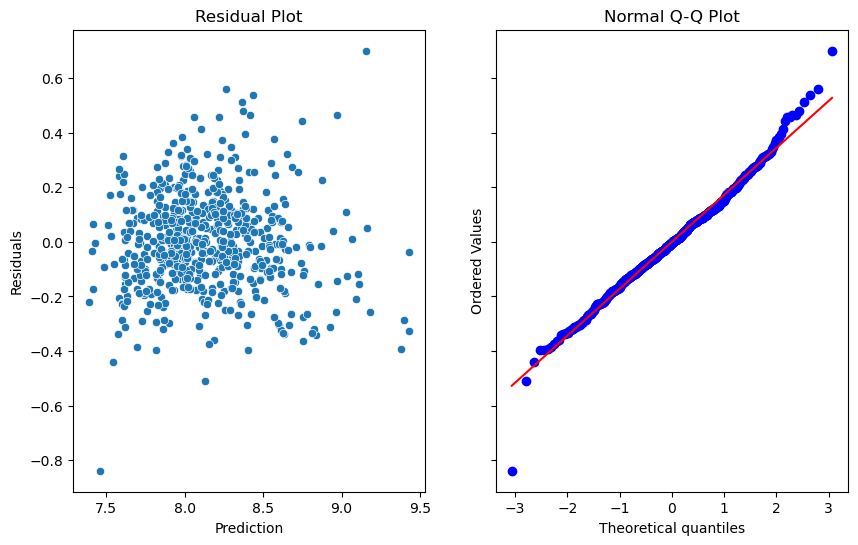

In [60]:
residual_analysis_plots(model)

In [61]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

pd.Series(
    [vif(X.values, i) for i in range(X.shape[1])],
    index=X.columns
)

const                        39.633144
sqft                          3.446538
beds                          2.750800
bath                          2.293482
laundry_not_in_unit           1.386200
parking_(b) protected         7.644575
parking_(c) off-street        2.222691
parking_(d) no parking        8.287782
hood_district_central         1.381181
hood_district_marina          1.383077
hood_district_north_beach     1.431221
hood_district_southwest       1.314278
hood_district_west            1.209656
dtype: float64

In [62]:
influence = model.get_influence()
inf_summary_df = influence.summary_frame()
inf_summary_df["cooks_d"].sort_values(ascending=False).head()

253    0.087658
56     0.040531
602    0.035615
598    0.029407
3      0.027646
Name: cooks_d, dtype: float64

In [63]:
X.loc[253]

const                           1.0
sqft                         2358.0
beds                            3.0
bath                            3.5
laundry_not_in_unit             0.0
parking_(b) protected           0.0
parking_(c) off-street          0.0
parking_(d) no parking          0.0
hood_district_central           0.0
hood_district_marina            0.0
hood_district_north_beach       0.0
hood_district_southwest         0.0
hood_district_west              0.0
Name: 253, dtype: float64

In [64]:
np.exp(y.loc[253])

18999.999999999993

## Model Fitting & Validation Scoring

In [77]:
final_model = sm.OLS(y, X).fit()

final_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     271.2
Date:                Fri, 15 Sep 2023   Prob (F-statistic):          2.96e-268
Time:                        21:47:08   Log-Likelihood:                 282.29
No. Observations:                 791   AIC:                            -538.6
Df Residuals:                     778   BIC:                            -477.8
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         7.7672      0.038    203.214      0.000       7.692       7.842
sqft                          0.0004   2.37e-05     16.614      0.000       0.000       0.000
beds                          0.0995      0.009     10.794      0.000       0.081       0.118
bath                          0.0452      0.016      2.782      0.006       0.013       0.077
laundry_not_in_unit          -0.0933      0.014     -6.526      0.000      -0.121      -0.065
parking_(b) protected        -0.1821      0.034     -5.379      0.000      -0.249      -0.116
parking_(c) off-street       -0.1886      0.046     -4.106      0.000      -0.279      -0.098
parking_(d) no parking       -0.2577      0.035     -7.371      0.000      -0.326      -0.189
hood_district_central         0.0304      0.019      1.610      0.108      -0.007       0.067
hood_district_marina          0.0859      0.021      3.997      0.000       0.044       0.128
hood_district_north_beach    -0.0213      0.018     -1.180      0.238      -0.057       0.014
hood_district_southwest      -0.1972      0.023     -8.544      0.000      -0.243      -0.152
hood_district_west           -0.0531      0.030     -1.784      0.075      -0.112       0.005
==============================================================================
Omnibus:                       18.350   Durbin-Watson:                   1.883
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.091
Skew:                           0.123   Prob(JB):                     6.52e-08
Kurtosis:                       3.971   Cond. No.                     1.25e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.25e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [78]:
print(mae(np.exp(y_test), np.exp(final_model.predict(X_test)))) 
# print(f"Test MAE: {mae(y_test, model.predict(X_test))}") #468.13 if not transformed
print(f"Test R2: {r2(y_test, final_model.predict(X_test))}")

440.43103847067664
Test R2: 0.7853759925636471
